In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from tqdm import tqdm
import scipy
import pandas as pd
import datetime

import lightgbm as lg

from collections import OrderedDict    # For recording the model specification 

import statsmodels.tools.numdiff as numdiff       # For numeric hessian
import scipy.linalg                    # For matrix inversion
from statsmodels.stats.descriptivestats import describe

import pylogit as pl                   # For choice model estimation
from pylogit import nested_logit as nl # For nested logit convenience funcs
from xlogit import MixedLogit, MultinomialLogit
import lightgbm as lgb
import catboost

from sklearn.preprocessing import binarize

import pickle
import json

In [2]:
df = pd.read_csv("data/newdata2122.csv", index_col=0)
df["classement"] = df["classement"].replace(['DA', 'NP', '0', 'A ', 'G ', 'D4', 'D3', 'R8', 'D5', 'D2', 'D8', 'D7', 'H8', 'D1', 'D6',
       'D9', 'G4', 'T ', 'G3', 'D ', 'G7', 'G2'], 10).astype(int)

C:\Users\raves\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (104,126,127,128,129) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [323]:
pd.to_datetime(test["date"]).apply(lambda x: x.year).value_counts()

2021    10878
2022     8069
1970     6685
Name: date, dtype: int64

In [286]:
df.groupby("id")["numPmu"].count().value_counts()

16    484
14    477
12    367
13    345
11    278
15    240
10    221
9     165
18     98
8      84
17     44
7      42
6       5
Name: numPmu, dtype: int64

In [240]:
# df = df.groupby("id").filter(lambda x: (x["numPmu"].count() == 14) | (x["numPmu"].count() == 16) | (x["numPmu"].count() == 12))

In [287]:
len(df.groupby("id"))

2850

In [14]:
sorted(list(df))

['acceleration_500m',
 'age',
 'allure',
 'avisEntraineur',
 'avisTrainer',
 'changementCategorie',
 'classement',
 'commentaireApresCourse_source',
 'commentaireApresCourse_texte',
 'date',
 'deferre',
 'dernierRapportDirect_dateRapport',
 'dernierRapportDirect_favoris',
 'dernierRapportDirect_grossePrise',
 'dernierRapportDirect_indicateurTendance',
 'dernierRapportDirect_nombreIndicateurTendance',
 'dernierRapportDirect_numPmu1',
 'dernierRapportDirect_permutation',
 'dernierRapportDirect_rapport',
 'dernierRapportDirect_typePari',
 'dernierRapportDirect_typeRapport',
 'dernierRapportReference_dateRapport',
 'dernierRapportReference_favoris',
 'dernierRapportReference_grossePrise',
 'dernierRapportReference_indicateurTendance',
 'dernierRapportReference_nombreIndicateurTendance',
 'dernierRapportReference_numPmu1',
 'dernierRapportReference_permutation',
 'dernierRapportReference_rapport',
 'dernierRapportReference_typePari',
 'dernierRapportReference_typeRapport',
 'dist',
 'distTo

In [4]:
feat = df.loc[:]

feat["lifepercwin"] = feat["nombreVictoires"] / feat["nombreCourses"]
feat["winPrace"] = feat["gainsParticipant_gainsCarriere"] / feat["nombreCourses"]
feat["newDist"] = abs(feat["last_race_dist"] - feat["dist"]) > 150

feat["publicProbaOfWinning"] = np.exp(1 / feat["dernierRapportDirect_rapport"])
feat["gainDifAnnePrec"] = feat["gainsParticipant_gainsAnneeEnCours"] / feat["gainsParticipant_gainsAnneePrecedente"]

feat.fillna(0,inplace=True)

feat.replace([np.inf, -np.inf], 0, inplace=True)

feat["bonne_reussite_hippo"] = binarize(feat["txReussiteHippo"].to_numpy().reshape(-1, 1),threshold=0.5)
feat["bonne_reussite_couple"] = binarize(feat["txReussiteCouple"].to_numpy().reshape(-1, 1),threshold=0.5)

feat["less_dist_than_last_race"] = (feat["last_race_dist"] > feat["dist"]).astype(int)
feat["dernierRapportReference_favoris"] = feat["dernierRapportReference_favoris"].astype(int)
feat["place_last_race"] = ((feat["lastPerf"] <= 3) & (feat["lastPerf"] >= 1)).astype(int)

feat["remontada"] = binarize(feat["gain_classement_fin"].to_numpy().reshape(-1, 1),threshold=0.25)
feat["avisTrainer"] = feat["avisTrainer"] - 2
feat["lessThanPreferedDist"] = binarize(feat["prefered_dist"].to_numpy().reshape(-1, 1),threshold=0)

feat["lastTimeToRecord"] = np.exp(feat["tpsLastRace"] - feat["recordAbs"])

feat["win"] = feat["classement"] == 1

feat["available"] = 1

feat["classement"] = feat["classement"].replace(0,10)
feat["win"] = feat["win"].replace(False,0)
feat["win"] = feat["win"].replace(True,1)


feat["newDist"] = feat["newDist"].astype(int)

feat.replace([np.inf, -np.inf], np.nan, inplace=True)

feat = feat.set_index(["id", df.groupby("id").cumcount()])
index = pd.MultiIndex.from_product(feat.index.levels, names=feat.index.names)
feat = feat.reindex(index, fill_value=0).reset_index(level=1, drop=True).reset_index()

nindex = len(df.groupby("id")) * list(range(1,feat.groupby("id").cumcount().max()+2))

feat = feat.assign(num=nindex)

feat = feat.groupby("id").filter(lambda x: x.win.sum() == 1)
feat["chid"] = feat["id"].astype(str) + "_1"

feat["classement"].replace(0, 10, inplace=True)

In [5]:
multiindex = [[],[]]

for i in feat.id.unique():
    for j in range(1,22):
        multiindex[0].append(i)
        multiindex[1].append(j)

In [6]:
# feat = feat.set_index(["id", df.groupby("id").cumcount()])
# test_index = pd.MultiIndex.from_arrays(multiindex, names=["id", "num"])
# feat = feat.reindex(test_index, fill_value=0).reset_index(level=1, drop=True).reset_index()

# nindex = len(df.groupby("id")) * list(range(1,feat.groupby("id").cumcount().max()+2))

# feat = feat.assign(num=nindex)
# feat[["id", "num","nom"]].head(25)

In [7]:
n_explo = 2

nfeat = feat.iloc[:18*(len(feat.groupby("id"))//2)].copy()

train = nfeat.copy()
# print(len(train.groupby("chid")))
# for i in range(2,n_explo+2):
#     cfeat = nfeat.copy()

#     cfeat["win"] = 0
#     cfeat.loc[cfeat["classement"].isin( list(range(1,i)) ), ~cfeat.columns.isin(["id","num","classement"])] = 0
#     cfeat.loc[cfeat["classement"].isin( list(range(1,i)) ),"classement"] = 10
#     cfeat.loc[cfeat["classement"] == i, "win"] = 1
#     cfeat["classement"] = cfeat["classement"] - 1
#     cfeat.loc[cfeat["nom"] == 0, "classement"] = 10
#     cfeat["chid"] = cfeat["id"].astype(str) + f"_{i}"
    
#     train = pd.concat([train, cfeat])
#     print(len(train.groupby("chid")))
train = train.sort_values(by=["id", "chid", "num"])

In [8]:
n_course = len(nfeat.groupby("id"))

# train = nfeat.loc[:].iloc[:18 * ( 2 * len(nfeat.groupby("chid"))//3)]
train = train.groupby("chid").filter(lambda x: x.win.sum() == 1)
test = feat.loc[:].iloc[18 * (len(feat.groupby("id")) // 2):]

In [25]:
set(list(feat)) - set(features)

NameError: name 'features' is not defined

In [13]:
ranker = pickle.load(open('models/rankerv1.pickle', 'rb'))
catboostranker = pickle.load(open('models/catboostranker.pickle', 'rb'))

In [108]:
model = MultinomialLogit()
# model = pickle.load(open('models/cl_v1.pickle', 'rb'))

In [9]:
features = ['nbVictoiresCouple','lifepercwin','meanPerf',
 'medianPerf',
 'modePerf','bonne_reussite_couple',
 'bonne_reussite_hippo','progressTps','prefered_dist_driver','moreFirstThanThirdCouple','gainDifAnnePrec','recordAbs','acceleration_500m','less_dist_than_last_race',
            "place_last_race", 'last_race_dist','tpsLastRace','timeSinceRecord',
 'minReduction','medianReduction','meanReduction','changementCategorie','distToPreferedDist','prefered_dist','jockeyHabitude',
 'nbDiscalifieMusic','nbVictoireMusic','nbPlaceMusic',
 'fer','gainsParticipant_gainsCarriere','sex','age','dist', 'firstTimeFer',
 'formePlace','formeVictoire','lastPerf','mean_dist_arrivee','nbVictoiresHippo','nombreCourses','nbCourseHippo',
 'txVictoireCouple','txVictoireHippo']

features_bac = ["fer","maxReduction_z","num","meanReduction_z","medianPerf_z","medianReduction_z","nbVictoiresTrainer_z","modePerf_z","nb2emeTandem_z","nb2emeCouple_z","newDist","timeBehindBestInRace_z","timeBehindBestMeanInRace_z","recordAbs_z","nbDiscalifieMusic_z","nbVictoireMusic","nbPlaceMusic","nombrePlacesSecond","nombrePlacesTroisieme_z","gainsParticipant_gainsAnneePrecedente_z","gainsParticipant_gainsVictoires_z","txReussiteTandem_z","lifepercwin","gainsParticipant_gainsAnneeEnCours_z", "txReussiteCouple_z", "nbCourseCouple_z","nbVictoiresCouple_z", "txReussiteTrainer_z", "timeSinceRecord_z", "nombreVictoires_z"]
# features = ["fer","nbDiscalifieMusic","timeBehindBestInRace_z","timeBehindBestMeanInRace_z","nombrePlacesSecond","nombrePlacesTroisieme_z", "txReussiteCouple_z", "nbCourseCouple_z","nbVictoiresCouple_z", "txReussiteTrainer_z", "timeSinceRecord_z", "nombreVictoires_z"]


# randvars = {name:"n" for name in features}
randvars={"nbDiscalifieMusic":"u"}

In [42]:
reduc_filt = train.loc[(train["reductionKilometrique"] != np.nan) & (train["reductionKilometrique"] > 0.0)]
# regressor = lg.LGBMRegressor()
# regressor.fit(reduc_filt[features], y=reduc_filt["reductionKilometrique"])

from sklearn import linear_model
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR


svm1 = SVR(C=1.0, epsilon=0.2)
# svm2 = SVR(degree=6, C=1.0, epsilon=0.2, max_iter=2000)
# svm3 = SVR(degree=5, C=1.0, epsilon=0.2)



ereg = VotingRegressor(estimators=[('svm1', svm1)])
ereg.fit(reduc_filt[features].to_numpy().reshape(-1,len(features)),reduc_filt["reductionKilometrique"].to_numpy())



VotingRegressor(estimators=[('svm1', SVR(epsilon=0.2))])

In [43]:
train_speed_pred = ereg.predict(train[features].to_numpy().reshape(-1,len(features)))
train["speed_pred"] = train_speed_pred

test_speed_pred = ereg.predict(test[features].to_numpy().reshape(-1,len(features)))
test["speed_pred"] = test_speed_pred

In [29]:
len(features)

43

In [226]:
catboostranker = catboost.CatBoostRanker()
catboostranker.fit(train[features],y=train["classement"],group_id=train["chid"], verbose=None)

0:	total: 36.1ms	remaining: 36s
1:	total: 64ms	remaining: 31.9s
2:	total: 89.3ms	remaining: 29.7s
3:	total: 116ms	remaining: 28.9s
4:	total: 146ms	remaining: 29.1s
5:	total: 173ms	remaining: 28.7s
6:	total: 198ms	remaining: 28.1s
7:	total: 226ms	remaining: 28.1s
8:	total: 256ms	remaining: 28.2s
9:	total: 284ms	remaining: 28.2s
10:	total: 310ms	remaining: 27.9s
11:	total: 336ms	remaining: 27.7s
12:	total: 362ms	remaining: 27.5s
13:	total: 387ms	remaining: 27.2s
14:	total: 412ms	remaining: 27s
15:	total: 437ms	remaining: 26.9s
16:	total: 467ms	remaining: 27s
17:	total: 493ms	remaining: 26.9s
18:	total: 518ms	remaining: 26.7s
19:	total: 543ms	remaining: 26.6s
20:	total: 568ms	remaining: 26.5s
21:	total: 593ms	remaining: 26.3s
22:	total: 619ms	remaining: 26.3s
23:	total: 644ms	remaining: 26.2s
24:	total: 670ms	remaining: 26.1s
25:	total: 700ms	remaining: 26.2s
26:	total: 726ms	remaining: 26.2s
27:	total: 752ms	remaining: 26.1s
28:	total: 777ms	remaining: 26s
29:	total: 802ms	remaining: 25.

243:	total: 7.15s	remaining: 22.2s
244:	total: 7.18s	remaining: 22.1s
245:	total: 7.22s	remaining: 22.1s
246:	total: 7.26s	remaining: 22.1s
247:	total: 7.3s	remaining: 22.1s
248:	total: 7.33s	remaining: 22.1s
249:	total: 7.37s	remaining: 22.1s
250:	total: 7.4s	remaining: 22.1s
251:	total: 7.43s	remaining: 22.1s
252:	total: 7.46s	remaining: 22s
253:	total: 7.49s	remaining: 22s
254:	total: 7.51s	remaining: 21.9s
255:	total: 7.54s	remaining: 21.9s
256:	total: 7.57s	remaining: 21.9s
257:	total: 7.6s	remaining: 21.9s
258:	total: 7.63s	remaining: 21.8s
259:	total: 7.66s	remaining: 21.8s
260:	total: 7.7s	remaining: 21.8s
261:	total: 7.73s	remaining: 21.8s
262:	total: 7.77s	remaining: 21.8s
263:	total: 7.8s	remaining: 21.8s
264:	total: 7.83s	remaining: 21.7s
265:	total: 7.86s	remaining: 21.7s
266:	total: 7.89s	remaining: 21.7s
267:	total: 7.93s	remaining: 21.7s
268:	total: 7.96s	remaining: 21.6s
269:	total: 7.99s	remaining: 21.6s
270:	total: 8.01s	remaining: 21.6s
271:	total: 8.04s	remaining: 

483:	total: 15.8s	remaining: 16.8s
484:	total: 15.8s	remaining: 16.8s
485:	total: 15.9s	remaining: 16.8s
486:	total: 15.9s	remaining: 16.7s
487:	total: 15.9s	remaining: 16.7s
488:	total: 15.9s	remaining: 16.7s
489:	total: 16s	remaining: 16.6s
490:	total: 16s	remaining: 16.6s
491:	total: 16s	remaining: 16.6s
492:	total: 16.1s	remaining: 16.5s
493:	total: 16.1s	remaining: 16.5s
494:	total: 16.1s	remaining: 16.5s
495:	total: 16.2s	remaining: 16.4s
496:	total: 16.2s	remaining: 16.4s
497:	total: 16.2s	remaining: 16.3s
498:	total: 16.2s	remaining: 16.3s
499:	total: 16.3s	remaining: 16.3s
500:	total: 16.3s	remaining: 16.2s
501:	total: 16.3s	remaining: 16.2s
502:	total: 16.4s	remaining: 16.2s
503:	total: 16.4s	remaining: 16.1s
504:	total: 16.4s	remaining: 16.1s
505:	total: 16.5s	remaining: 16.1s
506:	total: 16.5s	remaining: 16s
507:	total: 16.5s	remaining: 16s
508:	total: 16.5s	remaining: 16s
509:	total: 16.6s	remaining: 15.9s
510:	total: 16.6s	remaining: 15.9s
511:	total: 16.6s	remaining: 15.

722:	total: 24.8s	remaining: 9.48s
723:	total: 24.8s	remaining: 9.45s
724:	total: 24.8s	remaining: 9.41s
725:	total: 24.8s	remaining: 9.38s
726:	total: 24.9s	remaining: 9.34s
727:	total: 24.9s	remaining: 9.3s
728:	total: 24.9s	remaining: 9.27s
729:	total: 25s	remaining: 9.23s
730:	total: 25s	remaining: 9.19s
731:	total: 25s	remaining: 9.16s
732:	total: 25s	remaining: 9.12s
733:	total: 25.1s	remaining: 9.08s
734:	total: 25.1s	remaining: 9.05s
735:	total: 25.1s	remaining: 9.01s
736:	total: 25.2s	remaining: 8.98s
737:	total: 25.2s	remaining: 8.94s
738:	total: 25.2s	remaining: 8.9s
739:	total: 25.2s	remaining: 8.87s
740:	total: 25.3s	remaining: 8.83s
741:	total: 25.3s	remaining: 8.79s
742:	total: 25.3s	remaining: 8.76s
743:	total: 25.4s	remaining: 8.72s
744:	total: 25.4s	remaining: 8.69s
745:	total: 25.4s	remaining: 8.65s
746:	total: 25.4s	remaining: 8.62s
747:	total: 25.5s	remaining: 8.58s
748:	total: 25.5s	remaining: 8.54s
749:	total: 25.5s	remaining: 8.51s
750:	total: 25.6s	remaining: 8

959:	total: 32.1s	remaining: 1.34s
960:	total: 32.2s	remaining: 1.3s
961:	total: 32.2s	remaining: 1.27s
962:	total: 32.2s	remaining: 1.24s
963:	total: 32.3s	remaining: 1.21s
964:	total: 32.3s	remaining: 1.17s
965:	total: 32.4s	remaining: 1.14s
966:	total: 32.4s	remaining: 1.1s
967:	total: 32.4s	remaining: 1.07s
968:	total: 32.5s	remaining: 1.04s
969:	total: 32.5s	remaining: 1s
970:	total: 32.5s	remaining: 972ms
971:	total: 32.6s	remaining: 938ms
972:	total: 32.6s	remaining: 905ms
973:	total: 32.6s	remaining: 872ms
974:	total: 32.7s	remaining: 838ms
975:	total: 32.7s	remaining: 805ms
976:	total: 32.8s	remaining: 772ms
977:	total: 32.8s	remaining: 738ms
978:	total: 32.9s	remaining: 705ms
979:	total: 32.9s	remaining: 672ms
980:	total: 33s	remaining: 638ms
981:	total: 33s	remaining: 605ms
982:	total: 33s	remaining: 571ms
983:	total: 33.1s	remaining: 538ms
984:	total: 33.1s	remaining: 504ms
985:	total: 33.2s	remaining: 471ms
986:	total: 33.2s	remaining: 437ms
987:	total: 33.2s	remaining: 40

In [18]:
catpredict = catboostranker.predict(test[catboostranker.feature_names_],verbose=None)

train["rank_pred_cat"] = catboostranker.predict(train[catboostranker.feature_names_],verbose=None)

test["rank_pred_cat"] = catpredict
# test['rank_pred'] = test.groupby("chid")["rank_pred_cat"].rank("dense",ascending=True).astype(int)
# test['rank_pred'] = test.groupby("chid")["rank_pred_cat"].rank("first").astype(int)

In [228]:
ranker = lg.LGBMRanker(boosting_type="dart",n_estimators=1000,num_leaves=100, min_data_in_bin=50,max_bin=500,reg_alpha=0.01,metric="ndcg")
groups = train.groupby('chid').size().to_frame('size')['size'].to_numpy()
groups_test = test.groupby('chid').size().to_frame('size')['size'].to_numpy()

ranker.fit(train[features], y=train["classement"],eval_set=[(test[features], test["classement"])],
           eval_group=[groups_test],eval_metric="ndcg", group=groups,verbose=1000)

C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	valid_0's ndcg@1: 0.919531	valid_0's ndcg@2: 0.90603	valid_0's ndcg@3: 0.862947	valid_0's ndcg@4: 0.832565	valid_0's ndcg@5: 0.794391


LGBMRanker(boosting_type='dart', max_bin=500, metric='ndcg', min_data_in_bin=50,
           n_estimators=1000, num_leaves=100, reg_alpha=0.01)

In [112]:
# pickle.dump(second_model, open("models/second_model2.pickle", "wb"))

In [19]:
train_rank_pred = ranker.predict(train[ranker.feature_name_])
train["rank_pred"] = train_rank_pred

rank_pred = ranker.predict(test[ranker.feature_name_])
test["rank_pred"] = rank_pred
# test['rank_pred'] = test.groupby("chid")["rank_pred"].rank("dense",ascending=True).astype(int)
# test['rank_pred'] = test.groupby("chid")["rank_pred"].rank("first").astype(int)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

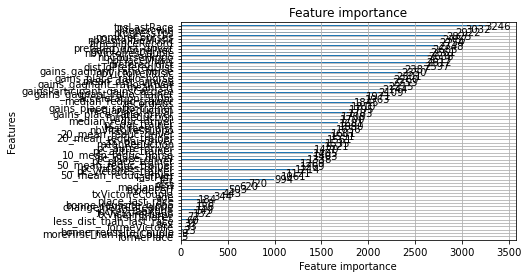

In [389]:
lgb.plot_importance(ranker)

In [24]:
test["rank_pred_proba"] = np.exp(test["rank_pred"]) / test.groupby("chid")["rank_pred"].transform(lambda x: sum(np.exp(x)))
train["rank_pred_proba"] = np.exp(train["rank_pred"]) / train.groupby("chid")["rank_pred"].transform(lambda x: sum(np.exp(x)))

In [441]:
sum(test[test["win"] == 1]["rank_pred"] == 1) / len(test[test["win"] == 1])

0.0

In [139]:
model.fit(X = train[features], y = train["win"], varnames=features, ids=train["chid"],alts=train["num"],avail=train["available"],maxiter=10000,tol_opts={"gtol": 1e-10})
model.summary()

Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 9
    Function evaluations: 10
Estimation time= 1.6 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
nbVictoiresCouple       0.0203848     0.0506499     0.4024638         0.736    
lifepercwin             0.0057279     0.0031199     1.8359278         0.148    
meanPerf               -0.1273686     0.0759707    -1.6765480         0.196    
medianPerf             -0.0899516     0.0580882    -1.5485356         0.241    
modePerf               -0.0044468     0.0209967    -0.2117859          0.78    
bonne_reussite_coup    -0.1178458     0.0940420    -1.2531193         0.364    
bonne_reussite_hipp     0.0760252     0.1020116     0.7452608         0.604    
progressTps             0.0157668     0.2050943     0

In [18]:
choice_estimate, proba_estimate = model.predict(X=train[features], varnames=features, ids=train["chid"], alts=train["num"],avail=train["available"],return_proba=True)
train["probaModel"] = proba_estimate.flatten()
train["probaModel"].replace(-np.inf,0, inplace=True)
train["probaModel"].fillna(0, inplace=True)

choice_estimate, proba_estimate = model.predict(X=test[features], varnames=features, ids=test["chid"], alts=test["num"],avail=test["available"],return_proba=True)
test["probaModel"] = proba_estimate.flatten()
test["probaModel"].replace(-np.inf,0, inplace=True)
test["probaModel"].fillna(0, inplace=True)

KeyError: "['gains_gagnant_ratio_driver', 'median_reduc_trainer', 'pc_dai_trainer', '20_mean_reduc_driver', 'gains_place_ratio_driver', 'pc_dai_driver', 'pc_victoires_trainer', '50_mean_reduc_driver', 'pc_autre_trainer', 'pc_autre_driver', 'gains_place_ratio_trainer', 'pc_place_trainer', '20_mean_reduc_trainer', '50_mean_reduc_trainer', 'gains_place_ratio_horse', 'median_reduc_driver', 'gains_gagnant_ratio_trainer', 'pc_place_driver', '10_mean_reduc_horse', 'pc_victoires_driver', 'gains_gagnant_ratio_horse'] not in index"

In [20]:
null_model = MultinomialLogit()
null_model.fit(X=train[["publicProbaOfWinning"]], y=train["win"], varnames=["publicProbaOfWinning"], ids=train["chid"],alts=train["num"],avail=train["available"])
null_model.summary()
# null_choice, null_proba = null_model.predict(X=test[["publicProbaOfWinning"]], varnames=["publicProbaOfWinning"], ids=test["id"], alts=test["num"], return_proba=True)

# accu = np.sum(winners == null_choice)/len(null_choice)
# print(f"Win%: {round(accu, 4) * 100}%, nbet: {len(choice)}")

Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 6
    Function evaluations: 7
Estimation time= 0.0 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
publicProbaOfWinnin     4.6658346     0.1356105    34.4061545     4.83e-188 ***
---------------------------------------------------------------------------
Significance:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log-Likelihood= -2961.365
AIC= 5924.730
BIC= 5929.992


In [44]:
train["speed_pred"] = (train["speed_pred"] - train["speed_pred"].mean()) / train["speed_pred"].std()
test["speed_pred"] = (test["speed_pred"] - test["speed_pred"].mean()) / test["speed_pred"].std()
train["speed_pred"]

0        0.762979
1        0.763245
2        0.584555
3        0.554968
4        0.577177
           ...   
25645    0.618947
25646    0.651066
25647    0.694831
25648    0.662872
25649   -1.444661
Name: speed_pred, Length: 25632, dtype: float64

In [57]:
# second_model = pickle.load(open('models/cl_v2.pickle', 'rb'))



train["mean_rank"] = np.exp(0.1*train["rank_pred"] + 0.9*train["rank_pred_cat"])
test["mean_rank"] = np.exp(0.1*test["rank_pred"] + 0.9*test["rank_pred_cat"])

# test["rank_pred_proba"] = np.exp(test["rank_pred"]) / test.groupby("chid")["rank_pred"].transform(lambda x: sum(np.exp(x)))
# train["rank_pred_proba"] = np.exp(train["rank_pred"]) / train.groupby("chid")["rank_pred"].transform(lambda x: sum(np.exp(x)))

# test["rank_pred_cat_proba"] = np.exp(test["rank_pred_cat"]) / test.groupby("chid")["rank_pred_cat"].transform(lambda x: sum(np.exp(x)))
# train["rank_pred_cat_proba"] = np.exp(train["rank_pred_cat"]) / train.groupby("chid")["rank_pred_cat"].transform(lambda x: sum(np.exp(x)))

varnames = ["publicProbaOfWinning","mean_rank"]

# second_model = pickle.load(open("models/second_model2.pickle", "rb"))

second_model = MultinomialLogit()
second_model.fit(X=train[varnames],y=train["win"],varnames=varnames, ids=train["chid"],alts=train["num"],avail=train["available"])
second_model.summary()

Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 11
    Function evaluations: 12
Estimation time= 0.0 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
publicProbaOfWinnin     2.1363235     0.1537225    13.8972680      3.52e-40 ***
mean_rank             -14.8218203     0.6286005   -23.5790766     8.09e-103 ***
---------------------------------------------------------------------------
Significance:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log-Likelihood= -2385.663
AIC= 4775.327
BIC= 4785.849


In [99]:
test = test[~test["id"].astype(str).str.contains("7500")]

choice, proba = second_model.predict(X=test[varnames],varnames=varnames, ids=test["id"],alts=test["num"],avail=test["available"], return_proba=True)

winners_odd = test.loc[test["win"] == 1]["dernierRapportDirect_rapport"].to_numpy()
winners = test.loc[test["win"] == 1]["num"].to_numpy()

odds = test["dernierRapportDirect_rapport"].to_numpy().reshape(-1,18)

def kelly(p,b):
    return (p-(1/b))/(1-1/b)

def expe(p,b):
    e = p*(b+1)
    m_e = np.argmax( e )
    return m_e, e[m_e]

accu = np.sum(winners == choice)/len(choice)
print(f"Win%: {round(accu, 4) * 100}%, nbet: {len(choice)}")

Win%: 30.44%, nbet: 1015


In [81]:
proba[0]

array([0.00995399, 0.07915694, 0.05754715, 0.00055926, 0.00110729,
       0.00701081, 0.17348436, 0.09798051, 0.09478275, 0.42119435,
       0.00692457, 0.05029802, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [82]:
# classifier = lg.LGBMClassifier()
# classifier.fit(train[["publicProbaOfWinning", "rank_pred_proba"]], y=train["win"])

In [83]:
test["proba"] = proba.flatten()

In [84]:
nb_chevaux = []
proba_moy_theo = []
proba_moy = []
rapport_moyen = []
classe = [0,0.01,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.4,1.]
inter = []
prob_real = []
for i,j in zip(classe, classe[1:]):
    inter.append(f"{i} à {j}")
    echantillon = proba.flatten()[(i < proba.flatten()) & (proba.flatten() <= j)]
    
    prob_r = len(test[(i < test["proba"] ) & (test["proba"] <=j ) & (test["win"] == 1)]) / len(test[(i < test["proba"] ) & (test["proba"] <=j )])
    prob_real.append(prob_r)
    
    rapport = test[(i < test["proba"] ) & (test["proba"] <=j ) & (test["win"] == 1 )]["dernierRapportDirect_rapport"].to_numpy()
    rapport_moyen.append(np.mean(rapport))
    nb_chevaux.append( len(echantillon ))
    proba_moy.append( np.mean(echantillon) )
    proba_moy_theo.append(np.mean([i,j]))
rapport_moy_theo = 1/np.array(proba_moy_theo)

In [85]:
pd.DataFrame({"PROBA": inter, "Proba moyenne théorique": proba_moy_theo, "Rapport théorique": rapport_moy_theo, "Proba moyenne": proba_moy,"Proba Reelle":prob_real,"Rapport moyen": rapport_moyen, "NB Chevaux": nb_chevaux})

,PROBA,Proba moyenne théorique,Rapport théorique,Proba moyenne,Proba Reelle,Rapport moyen,NB Chevaux
0,0 à 0.01,0.0050,200.000000,0.002356,0.019042,29.892135,4674
1,0.01 à 0.025,0.0175,57.142857,0.016704,0.035857,16.987302,1757
2,0.025 à 0.05,0.0375,26.666667,0.036301,0.050214,18.164634,1633
3,0.05 à 0.1,0.0750,13.333333,0.072919,0.076077,11.498742,2090
4,0.1 à 0.15,0.1250,8.000000,0.123329,0.115843,10.986029,1174
5,0.15 à 0.2,0.1750,5.714286,0.171877,0.137841,7.029245,769
6,0.2 à 0.25,0.2250,4.444444,0.224542,0.151329,5.312162,489
7,0.25 à 0.3,0.2750,3.636364,0.273123,0.216495,4.657143,291
8,0.3 à 0.4,0.3500,2.857143,0.342707,0.288525,3.997727,305
9,0.4 à 1.0,0.7000,1.428571,0.545999,0.440341,2.486452,352


In [86]:
accu = np.sum(winners == choice)/len(choice)
print(f"Win%: {round(accu, 4) * 100}%, nbet: {len(choice)}")

Win%: 30.44%, nbet: 1015


In [211]:
test["date"] = pd.to_datetime(test["date"])

In [61]:
test["date"][test["date"] != "1970-01-01"].min()

Timestamp('2021-01-31 00:00:00')

In [34]:
with open("data/rapport.json", "r") as f:
    rapports = json.load(f)
# with open("data/rapport2.json", "r") as f:
#     rapports.update(json.load(f))

In [252]:
test[test["rank_pred"] == 1][["id","win"]]

,id,win
25659,2021082414751,0
25675,2021082414752,1
25690,2021082414753,0
25709,2021082414755,0
25726,2021082414756,0
...,...,...
51218,2022121375002,0
51234,2022121375003,0
51249,2022121375005,0
51274,2022121375007,1


In [76]:
test[~test["id"].astype(str).str.contains("7500")]

,id,nom,numPmu,age,sexe,race,statut,oeilleres,proprietaire,entraineur,...,lessThanPreferedDist,lastTimeToRecord,win,available,chid,speed_pred,rank_pred_cat,rank_pred,mean_rank,proba
25650,2021082414751,ENDRIX BLEU,1,7,HONGRES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,A. BESNARD,J.F. POPOT,...,0.0,0.130910,0,1,2021082414751_1,0.819700,-1.355645,-0.130382,0.291382,0.009954
25651,2021082414751,EDOLINE DAIRPET,2,7,FEMELLES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,Mlle M. LECOURT,F. DELANOE,...,1.0,0.316180,0,1,2021082414751_1,0.776143,-1.999957,-0.739003,0.153530,0.079157
25652,2021082414751,ETOILE VICTORY,3,7,FEMELLES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,Mme P. DAUDEVILLE,P. SORAIS,...,1.0,0.347533,0,1,2021082414751_1,0.801502,-1.879142,-0.613520,0.173326,0.057547
25653,2021082414751,ELTON TRAFO,4,7,HONGRES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,L. VANBROEKHOVEN,L. VANBROEKHOVEN,...,0.0,0.442638,0,1,2021082414751_1,0.807944,-0.979497,1.644273,0.488156,0.000559
25654,2021082414751,EPIDAURE DUB'S,5,7,HONGRES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,Ecurie Vincent RAIMBAULT,V. RAIMBAULT,...,1.0,4.842988,0,1,2021082414751_1,0.880063,-0.841950,-0.646267,0.439384,0.001107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51133,2022121244138,0,0,0,0,0,0,0,0,0,...,0.0,0.000000,0,0,2022121244138_1,-1.547615,4.101125,11.136855,122.082603,0.000000
51134,2022121244138,0,0,0,0,0,0,0,0,0,...,0.0,0.000000,0,0,2022121244138_1,-1.547615,4.101125,11.136855,122.082603,0.000000
51135,2022121244138,0,0,0,0,0,0,0,0,0,...,0.0,0.000000,0,0,2022121244138_1,-1.547615,4.101125,11.136855,122.082603,0.000000
51136,2022121244138,0,0,0,0,0,0,0,0,0,...,0.0,0.000000,0,0,2022121244138_1,-1.547615,4.101125,11.136855,122.082603,0.000000


       mean   max  min  median
0  3.491597  29.2  1.1     2.6
41.03448275862069% de win, 119
253€ 290 paris
Max drawdown: -21%


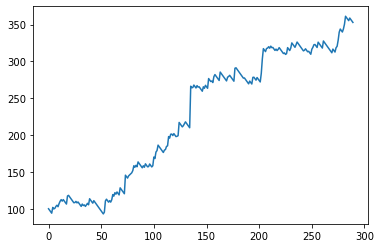

In [105]:
place = []
courses_list = test["id"].unique()

rapport_won = []
evo = [100]
money = 100
wins = 0

pub_prob = test["publicProbaOfWinning"].to_numpy().reshape(-1,df.groupby("id")["numPmu"].count().max())

won_id = []

gain_place = []
gain_gagnant = []
max_dd = 0

for i in range(len(choice)):
    choice_in_df = test[(test["id"] == courses_list[i]) & (test["num"] == choice[i])].iloc[0]
    sorted_proba = np.argsort(proba[i])
    p = proba[i, sorted_proba[-1]]
    odd = choice_in_df["dernierRapportDirect_rapport"]
    expe = p * odd - (1-p)
    
#     SR = (proba[i, :] - (1/odds[i, :])) / np.sqrt(proba[i, :] * (1-proba[i, :]))
#     sr_sort = np.argsort(SR)
    
    proba_jumele = proba[i, sorted_proba[-1]] * (proba[i, sorted_proba[-2]]**(0.76))/ (1-proba[i, sorted_proba[-1]])**(0.76)
    proba_trio = 0    
    proba_jumele_public = pub_prob[i, sorted_proba[-1]] * (pub_prob[i, sorted_proba[-2]]**(0.76))/ np.sum(np.delete(pub_prob[i],sorted_proba[-1])**(0.76))
    proba_trio_public = 0
    proba_jumele += proba[i, sorted_proba[-2]] * (proba[i, sorted_proba[-1]]**(0.76))/ (1-proba[i, sorted_proba[-2]])**(0.76)
    proba_jumele_public += pub_prob[i, sorted_proba[-2]] * (pub_prob[i, sorted_proba[-1]]**(0.76)) / np.sum(np.delete(pub_prob[i],sorted_proba[-2])**(0.76))
# #     print(proba_jumele)
    
    combinaisons_trio = [[1,2,3],[1,3,2],[2,1,3],[2,3,1],[3,2,1],[3,1,2]]
    
    for combi in combinaisons_trio:
        proba_trio += proba[i, sorted_proba[-combi[0]]] * (proba[i, sorted_proba[-combi[1]]]**(0.76)) * (proba[i, sorted_proba[-combi[2]]]**(0.84))/ np.sum(proba[i])**(0.76)
        proba_trio_public += pub_prob[i, sorted_proba[-combi[0]]] * (pub_prob[i, sorted_proba[-combi[1]]]**(0.76)) * (pub_prob[i, sorted_proba[-combi[2]]]**(0.84))/ np.sum(pub_prob[i])**(0.76)

    
#     proba_public += pub_prob[i, sorted_proba[-2]] * (pub_prob[i, sorted_proba[-1]]**(0.76))/ np.sum(np.delete(pub_prob[i],sorted_proba[-2])**(0.76))
    
    bet_size = np.ceil(1 + 0.005*money)
    if str(choice_in_df.id) in rapports:
#         if "E_SIMPLE_PLACE" in rapports[str(choice_in_df.id)]:
#             if True:
#                 frackel = max(1, money * kelly(np.average([p, 1/odd]), odd) /4)
#                 odds_pmu = rapports[str(choice_in_df.id)]["E_SIMPLE_PLACE"]["rapports"]
#                 for j in odds_pmu:

#                     if all([x in [sorted_proba[-1] + 1] for x in j["combinaison"]]):
# #                         print("GAGNANT",(j["dividendePourUnEuro"] / 100), j["combinaison"],p, odd)

#                         money += frackel*j["dividendePourUnEuro"] / 100
#                         rapport_won.append(j["dividendePourUnEuro"] / 100)
#                         won_id.append(courses_list[i])
#                         wins+=1
#                 money-=frackel
#                 gain_gagnant.append(money-evo[-1])
#                 evo.append(money)
#         if "E_SIMPLE_GAGNANT" in rapports[str(choice_in_df.id)]:
#             if expe > 0:
#                 odds_pmu = rapports[str(choice_in_df.id)]["E_SIMPLE_GAGNANT"]["rapports"]
#                 for j in odds_pmu:

#                     if all([x in [sorted_proba[-1] + 1] for x in j["combinaison"]]):
# #                         print("GAGNANT",(j["dividendePourUnEuro"] / 100), j["combinaison"],p, odd)

#                         money += 1*j["dividendePourUnEuro"] / 100
#                         rapport_won.append(j["dividendePourUnEuro"] / 100)
#                         won_id.append(courses_list[i])
#                         wins+=1
#                 money -= 1
#                 gain_gagnant.append(money-evo[-1])
#                 evo.append(money)
#         if "E_COUPLE_GAGNANT" in rapports[str(choice_in_df.id)]:         
#             if proba_jumele > proba_jumele_public: 
#                 odds_pmu = rapports[str(choice_in_df.id)]["E_COUPLE_GAGNANT"]["rapports"]
#                 for j in odds_pmu:
#                     if sorted_proba[-1] + 1 in j["combinaison"] and all([x in [sorted_proba[-1] + 1,sorted_proba[-2] + 1,sorted_proba[-3] + 1,sorted_proba[-4] + 1] for x in j["combinaison"]]):

#                         money += 0.1 * j["dividendePourUnEuro"] / 100
#                         rapport_won.append(j["dividendePourUnEuro"] / 100)
#                         won_id.append(courses_list[i])
# #                         print("CP",(j["dividendePourUnEuro"] / 100), j["combinaison"], bet_size * j["dividendePourUnEuro"] / 100)
#                         wins+=1
                        

#                 money-= 0.3
#                 gain_place.append(money-evo[-1])
#                 evo.append(money)
                
        if "E_DEUX_SUR_QUATRE" in rapports[str(choice_in_df.id)]:         
            if True: 
                odds_pmu = rapports[str(choice_in_df.id)]["E_DEUX_SUR_QUATRE"]["rapports"]
                for j in odds_pmu:
                    if all([x in [sorted_proba[-1] + 1,sorted_proba[-2] + 1] for x in j["combinaison"]]):

                        money += 2*j["dividendePourUnEuro"] / 100
                        rapport_won.append(j["dividendePourUnEuro"] / 100)
                        won_id.append(courses_list[i])
#                         print("2sur4",(j["dividendePourUnEuro"] / 100), j["combinaison"], bet_size * j["dividendePourUnEuro"] / 100)
                        wins+=1
                        break
                        

                money -= 2
                gain_place.append(money-evo[-1])
                evo.append(money)
                
#         if "E_TRIO" in rapports[str(choice_in_df.id)]:
#             if True: 
#                 odds_pmu = rapports[str(choice_in_df.id)]["E_TRIO"]["rapports"]
#                 for j in odds_pmu:
#                     if sorted_proba[-1] + 1 in j["combinaison"] and all([x in [sorted_proba[-1] + 1,sorted_proba[-2] + 1,sorted_proba[-3] + 1,sorted_proba[-4] + 1,sorted_proba[-5] + 1] for x in j["combinaison"]]):

#                         money += 0.1 * j["dividendePourUnEuro"] / 100
#                         rapport_won.append(j["dividendePourUnEuro"] / 100)
#                         won_id.append(courses_list[i])
# #                         print("TRIO",(j["dividendePourUnEuro"] / 100), j["combinaison"],[sorted_proba[-1] + 1,sorted_proba[-2] + 1,sorted_proba[-3] + 1,sorted_proba[-4] + 1], bet_size * j["dividendePourUnEuro"] / 100)
#                         wins+=1
#                         break

#                 money-= 0.6
#                 gain_place.append(money-evo[-1])
#                 evo.append(money)
#         if "E_MINI_MULTI" in rapports[str(choice_in_df.id)]:
#             if True: 
#                 odds_pmu = rapports[str(choice_in_df.id)]["E_MINI_MULTI"]["rapports"]
#                 for j in odds_pmu:
#                     if j['libelle'] == 'e-Mini Multi en 4':
#                         if sorted_proba[-1] + 1 in j["combinaison"] and all([x in [sorted_proba[-1] + 1,sorted_proba[-2] + 1,sorted_proba[-3] + 1,sorted_proba[-4] + 1,sorted_proba[-5] + 1] for x in j["combinaison"]]):

#                             money += 0.5 * j["dividendePourUnEuro"] / 100
#                             rapport_won.append(j["dividendePourUnEuro"] / 100)
#                             won_id.append(courses_list[i])
# #                             print("E_MINI_MULTI",(j["dividendePourUnEuro"] / 100), j["combinaison"],[sorted_proba[-1] + 1,sorted_proba[-2] + 1,sorted_proba[-3] + 1,sorted_proba[-4] + 1], bet_size * j["dividendePourUnEuro"] / 100)
#                             wins+=1
#                             break

#                 money-= 2
#                 gain_place.append(money-evo[-1])
#                 evo.append(money)
#         if "E_PICK5" in rapports[str(choice_in_df.id)]:         
#             if True: 
#                 odds_pmu = rapports[str(choice_in_df.id)]["E_PICK5"]["rapports"]
#                 for j in odds_pmu:
#                     if all([x in [sorted_proba[-1] + 1,sorted_proba[-2] + 1,sorted_proba[-3] + 1,sorted_proba[-4] + 1,sorted_proba[-5] + 1] for x in j["combinaison"]]):

#                         money += 0.5 * j["dividendePourUnEuro"] / 100
#                         rapport_won.append(j["dividendePourUnEuro"] / 100)
#                         won_id.append(courses_list[i])
# #                         print("E_PICK5",(j["dividendePourUnEuro"] / 100), j["combinaison"], bet_size * j["dividendePourUnEuro"] / 100)
#                         wins+=1
#                         break

#                 money-=0.5
#                 gain_place.append(money-evo[-1])
#                 evo.append(money)
    max_dd = min( (money - max(evo)) / max(evo) , max_dd)


rapport_won = np.array(rapport_won)
print(describe(rapport_won, stats=["max", "min", "mean", "median"]).T)
print(f"{wins/len(evo)*100}% de win, {wins}")
print(f"{int(money-evo[0])}€ {len(evo)} paris")
print(f"Max drawdown: {int(max_dd*100)}%")
evo = np.array(evo)
plt.plot(evo)
#plt.title("Simple Placé, 2sur4, Trio, Couplé Placé en misant 0.5% de la bankroll sur chaque paris");

In [333]:
print(len(gain_place),sum(gain_place),"|",len(gain_gagnant),sum(gain_gagnant))
print(min(evo))

2728 562.6999999999931 | 0 0
28.800000000000754


In [94]:
lstreak = 0
last = 100
mlstreak = 0
for i in evo:
    if i < last:
        lstreak +=1
    else:
        lstreak = 0
    last = i
    mlstreak = max(lstreak, mlstreak)
print(mlstreak)

9


In [104]:
test.loc[test["id"] == won_id[-1]][["num","numCoursePMU", "classement","date","dernierRapportDirect_rapport"]]

,num,numCoursePMU,classement,date,dernierRapportDirect_rapport
50040,1,R4C7,10,2022-11-05,37.0
50041,2,R4C7,7,2022-11-05,78.0
50042,3,R4C7,10,2022-11-05,6.7
50043,4,R4C7,4,2022-11-05,3.1
50044,5,R4C7,9,2022-11-05,33.0
50045,6,R4C7,10,2022-11-05,25.0
50046,7,R4C7,10,2022-11-05,20.0
50047,8,R4C7,10,2022-11-05,53.0
50048,9,R4C7,5,2022-11-05,16.0
50049,10,R4C7,6,2022-11-05,12.0


In [93]:
dquatre = 0
cp = 0
for i in rapports:
    if "E_DEUX_SUR_QUATRE" in rapports[i]:
        dquatre += 1
    if "E_COUPLE_PLACE" in rapports[i]:
        cp += 1
print(dquatre,cp)

2554 2956


In [44]:
test.loc[test["id"] == race_id[2]][["id", "num","numCoursePMU", "classement","date","dernierRapportDirect_rapport"]]

,id,num,numCoursePMU,classement,date,dernierRapportDirect_rapport
26046,2021082943015,1,R8C5,10,2021-08-29,91.0
26047,2021082943015,2,R8C5,9,2021-08-29,31.0
26048,2021082943015,3,R8C5,6,2021-08-29,16.0
26049,2021082943015,4,R8C5,7,2021-08-29,5.6
26050,2021082943015,5,R8C5,5,2021-08-29,27.0
26051,2021082943015,6,R8C5,10,2021-08-29,63.0
26052,2021082943015,7,R8C5,2,2021-08-29,2.4
26053,2021082943015,8,R8C5,8,2021-08-29,9.9
26054,2021082943015,9,R8C5,3,2021-08-29,7.0
26055,2021082943015,10,R8C5,4,2021-08-29,20.0


In [74]:
def recsum(x):
    return sum([i for i in range(x+1)])

      mean   max  min  median
0  14.2925  69.0  1.7    9.15
Win%: 0.060240963855421686, nwin: 40,nbet: 664, ncourses: 664
Gain de -92€, gain moyen de 4.82%
Max lose streak: 76


<ipython-input-225-6910d7bd3b5f>:41: RuntimeWarning: divide by zero encountered in true_divide
  SR = (proba[i, :] - (1/odds[i, :])) / np.sqrt(proba[i, :] * (1-proba[i, :]))


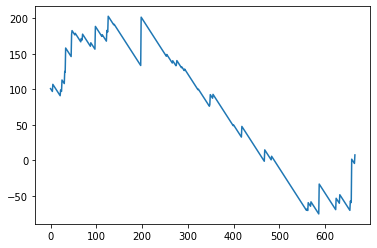

In [225]:
win = 0
tot = 0
odds_winned = []
expe_won = []
proba_won = []

proba_lost = []
odds_lost= []

money = 100
evo = [101,money]

lstreak = 0

max_lstreak = 0

sorted_proba = np.argsort(proba)

race_id = []

bet = []

gain = []

c_1 = 0
c_2 = 0

for i in range(len(choice)):
    cheval,Er = expe(proba[i], odds[i])
#     place_best = sorted_proba[i, -3:]
    
#     best_place,Er = expe(proba[i], odds[i])
#     print(best_place,Er, place_best[best_place])
#     best_expe = place_best[best_place]
    
    er = proba[i, :] * odds[i, :]
    
    er_sorted = np.argsort(er)
    best_espe = er_sorted[-1] + 1 
    
    SR = (proba[i, :] - (1/odds[i, :])) / np.sqrt(proba[i, :] * (1-proba[i, :]))
    
    c = np.argmax(SR)
    
    choice_expe = proba[i, c] * odds[i][c] - (1-proba[i, c])
    schoice_expe = proba[i, sorted_proba[-2]] * odds[i][sorted_proba[-2]]
    
#     b_espe = sorted_proba[-1] if choice_expe > schoice_expe else sorted_proba[-2]
#     max_espe = max(choice_expe,schoice_expe)

#     c = sorted_proba[i,-1]

#     b1=1
#     wagger1 =  kelly(np.mean([proba[i][c],1/odds[i][c]]),odds[i][c]) / 5
    if True:
#         wagger2 = kelly(proba[i][sorted_proba[-2]],odds[i][sorted_proba[-2]]) / 3
#         bet_value = min(wagger*money/3, 0.05*money)
#         b1 = max(np.ceil(0.02*money),min(money//2, odds[i][choice[i] - 1]))
#         b1 = np.ceil(wagger1 * money)
        b1 = 1
        if c+1 == winners[i]:
            race_id.append( test["id"].unique()[i] )
            win += 1
#             print(f"Win le {winners[i]} a gagné  avec une cote de {odds[i][c]}, {b1}, {money}")
            money += odds[i][c] * b1
            gain+=[(odds[i][c] * b1)/money]
            odds_winned.append(odds[i][c])
            expe_won.append(choice_expe)
            proba_won.append(proba[i, c])
            lstreak = 0
        else:
            proba_lost.append(proba[i, c])
            odds_lost.append(odds[i, c])
            gain+=[-b1/money]
            lstreak+=1
            
        money -= b1
        
        max_lstreak = max(max_lstreak, lstreak)
        
        bet.append(b1)
        evo.append(money)
        tot+=1
        
print(describe(odds_winned, stats=["max", "min", "mean", "median"]).T)
# print(describe(expe_won, stats=["max", "min", "mean", "median"]).T)
print(f"Win%: {win/tot}, nwin: {win},nbet: {tot}, ncourses: {len(choice)}")
print(f"Gain de {int(money-100)}€, gain moyen de {round(np.mean(gain)*100,2)}%")
print("Max lose streak:", max_lstreak)
plt.plot(evo)
# plt.yscale("log")

In [126]:
evo

[101,
 100,
 102.5,
 102.5,
 101.5,
 100.5,
 99.5,
 99.5,
 98.5,
 97.5,
 100.4,
 106.30000000000001,
 105.30000000000001,
 111.9,
 110.9,
 110.9,
 110.9,
 110.9,
 109.9,
 107.9,
 107.9,
 110.7,
 110.7,
 110.7,
 108.7,
 108.7,
 107.7,
 106.7,
 106.7,
 105.7,
 104.7,
 105.9,
 105.9,
 105.9,
 105.9,
 105.9,
 104.9,
 103.9,
 103.9,
 104.80000000000001,
 104.80000000000001,
 103.80000000000001,
 107.60000000000001,
 108.00000000000001,
 108.00000000000001,
 107.00000000000001,
 107.30000000000001,
 107.30000000000001,
 107.30000000000001,
 107.30000000000001,
 106.30000000000001,
 105.30000000000001,
 105.30000000000001,
 104.30000000000001,
 104.30000000000001,
 103.30000000000001,
 102.30000000000001,
 100.30000000000001,
 100.30000000000001,
 100.30000000000001,
 100.30000000000001,
 99.30000000000001,
 98.30000000000001,
 98.30000000000001,
 98.80000000000001,
 98.80000000000001,
 96.80000000000001,
 96.80000000000001,
 96.80000000000001,
 96.80000000000001,
 96.80000000000001,
 96.8000

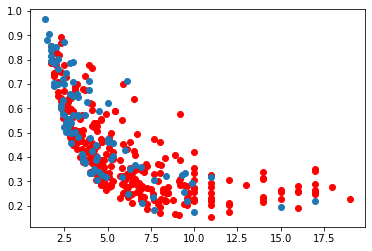

In [95]:
plt.scatter(odds_lost, proba_lost, color="r")
plt.scatter(odds_winned, proba_won)

# LL Estimation harville

In [144]:
from scipy.optimize import minimize

1424

In [149]:
gamma = 0
delta = 0
proba_gamma = proba**gamma / np.sum(proba**gamma)
proba_delta =  proba**delta / np.sum(proba**delta)

In [155]:
proba * proba_gamma * proba_delta

array([[2.05334479e-11, 1.34085689e-10, 1.00661581e-10, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.42521459e-10, 4.61287598e-11, 7.42302050e-13, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.95371660e-11, 1.17227386e-10, 2.48109325e-10, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.64642241e-10, 1.40685312e-10, 5.01790567e-11, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.53254145e-17, 4.91776818e-11, 2.40954218e-12, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.63493485e-11, 6.29902433e-10, 1.99191304e-11, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [ ]:
def log_ll(x):
    gamma = x[0]
    delta = x[1]
    
    return np.log()